<a href="https://colab.research.google.com/github/nescribal/cef/blob/master/Boston_housing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow import keras
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


57344/57026 [==============================] - 0s 0us/step


Normaliza data

In [3]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Build model

In [4]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64,activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

Because it is small dataset, we use k-fold validation

In [8]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i* num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i* num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]], 
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]], 
       axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets),
            epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
average_mae_history = [
  np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

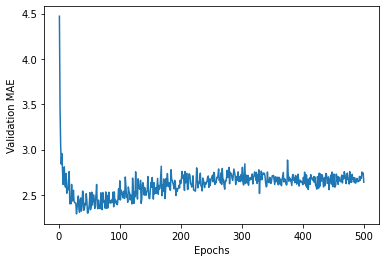

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

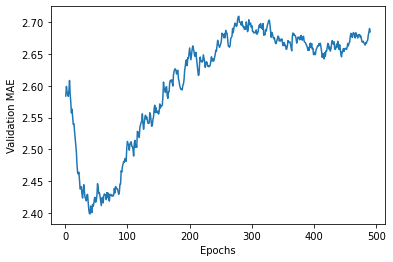

In [11]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

After 80 epochs model starts overfiting, so let's rewrite the model

In [13]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 1ms/step - loss: 17.0856 - mae: 2.5955


2.595463275909424